# ToDo
добавить реальные роторы

In [1]:
import os
from tqdm.auto import tqdm, trange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

In [3]:
mps_is_ok = torch.backends.mps.is_built() and torch.backends.mps.is_available()
device = torch.device('mps' if mps_is_ok else 'cpu')
print(device)

mps


In [4]:
device = torch.device("cpu")

# Dataset

In [5]:
def standardize(X, ϵ=1e-9):
    # X : [BATCH x CHANNEL x LENGTH]
    X_mean = X.mean(dim=2, keepdim=True)
    X_std = X.std(dim=2, keepdim=True)
    return (X - X_mean) / (X_std + ϵ)

## Real

In [5]:
def split_filename(filename):
    # ex: M15-G3-S0-2.csv
    h, g, s, i = filename.split("-")
    h, g, s = map(lambda x: int(x[1:]), [h, g, s])
    i = int(i.split(".")[0])
    return h, g, s, i

In [6]:
folder_dataset = "/Users/andrey/Work/HPL/projects/rheeda/rotor-dataset/"

rows = []

for filename in os.listdir(folder_dataset):
    
    h, g, s, i = split_filename(filename)
    row = {
        "filename": filename,
        "heart": h,
        "group": g,
        "stim": s,
        "i": i
    }
    rows.append(row)
    
df_dataset = pd.DataFrame(rows)

In [7]:
mask_test = (df_dataset.heart == 13) & (df_dataset.group == 2)
mask_test |= (df_dataset.heart == 15) & (df_dataset.group == 3)

df_dataset["fold"] = "train"
df_dataset.loc[mask_test, "fold"] = "test"

In [8]:
class RotorDataset(Dataset):
    
    def __init__(
        self,
        folder_dataset,
        df_dataset,
        window_size=256,
        window_step=None,
        columns=None
    ):
        
        self.window_size = window_size
        self.window_step = window_size if window_step is None else window_step

        self.X = []
        self.Y = []
        
        df_concat = []        
        columns_xyz = ["x", "y", "z"]
        
        for _, row in tqdm(list(df_dataset.iterrows())):
            
            filename = os.path.join(
                folder_dataset,
                row.filename
            )
        
            df = pd.read_csv(filename)
            df = df[::10]
            
            df[columns_xyz] -= df[columns_xyz].iloc[0]
            
            if len(df_concat):
                df_last = df_concat[-1]
                df[columns_xyz] += df_last[columns_xyz].iloc[-1]
                
            df_concat.append(df)
            
        df_concat = pd.concat(df_concat, ignore_index=True)
        proba = df_concat["class"]
            
        for i in trange(0, len(df_concat) - self.window_size, self.window_step):                    
            x = df_concat[columns_xyz][i: i + window_size].values.T
            y = proba[i: i + window_size]
            self.X.append(x)        
            self.Y.append(y)
                
        self.N = len(self.X)

        self.X = np.stack(self.X)
        self.X = torch.tensor(self.X, dtype=torch.float32)
        
        self.Y = np.stack(self.Y)
        self.Y = torch.tensor(self.Y, dtype=torch.float32)
        # self.Y = nn.functional.one_hot(self.Y).float()
        
        self.df_concat = df_concat
                
    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

In [9]:
WINDOW_SIZE = 64

dataset_train = RotorDataset(
    folder_dataset, 
    df_dataset[df_dataset.fold == "train"],
    window_size=WINDOW_SIZE,
    window_step=WINDOW_SIZE // 2
)

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/2291 [00:00<?, ?it/s]

In [10]:
dataset_test = RotorDataset(
    folder_dataset, 
    df_dataset[df_dataset.fold == "test"],
    window_size=WINDOW_SIZE,
    window_step=WINDOW_SIZE // 2
)

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/904 [00:00<?, ?it/s]

## Synthetic

In [6]:
filename = "../data/synthetic-latest.csv"
df = pd.read_csv(filename)

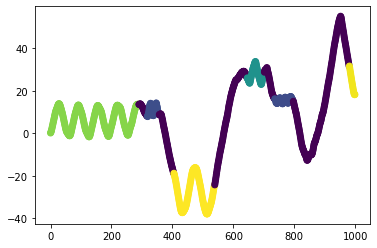

In [7]:
plt.scatter(df.index[:1_000], df.y[:1_000], c=df["proba"][:1_000])

In [8]:
def create_markup(df, α=1.5):
    counts = df.proba.value_counts()
    counts = (counts * 10 / counts.index > α) & (counts.index > 0)
    counts = counts.astype(float)
    result = df.copy()
    result.proba.replace(counts, inplace=True)
    return result

In [9]:
class RotorDataset(Dataset):
    
    def __init__(
        self,
        df,
        window_size=256,
        window_step=None
    ):
        
        self.window_size = window_size
        self.window_step = window_size if window_step is None else window_step

        self.X = []
        self.Y = []
        
        columns_xyz = ["x", "y", "z"]
        proba = df["proba"]
        self.df = df
            
        for i in trange(
            0,
            len(df) - self.window_size,
            self.window_step
        ):       
            df_window = df[i: i + window_size]
            df_window = create_markup(df_window)
            x = df_window[columns_xyz].values.T
            y = df_window["proba"]
            self.X.append(x)        
            self.Y.append(y)
                
        self.N = len(self.X)

        self.X = np.stack(self.X)
        self.X = torch.tensor(self.X, dtype=torch.float32)
        
        self.X = standardize(self.X)
        
        self.Y = np.stack(self.Y)
        self.Y = torch.tensor(self.Y, dtype=torch.float32)
        # self.Y = nn.functional.one_hot(self.Y).float()
                        
    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

In [10]:
# df = df[:4096]

In [11]:
i_train = len(df) * 8 // 10
WINDOW_SIZE = 256
WINSOW_STEP = WINDOW_SIZE // 4
dataset_train = RotorDataset(
    # pd.concat([df[:i_train], df[:i_train][:-1]]),
    df[:i_train],
    window_size=WINDOW_SIZE,
    window_step=WINSOW_STEP
)

dataset_test = RotorDataset(
    # pd.concat([df[i_train:], df[i_train:][::-1]]),
    df[i_train:],
    window_size=WINDOW_SIZE,
    window_step=WINSOW_STEP
)

  0%|          | 0/1880 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

In [12]:
dataset_train.X += torch.rand_like(dataset_train.X) / 10
dataset_test.X += torch.rand_like(dataset_test.X) / 10

In [13]:
dataset_train.X.shape

torch.Size([1880, 3, 256])

In [14]:
dataset_train.Y.shape

torch.Size([1880, 256])

In [15]:
x, y = dataset_train[32]

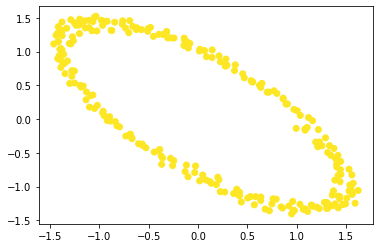

In [16]:
plt.scatter(x[0], x[1], c=y, vmin=0, vmax=1)

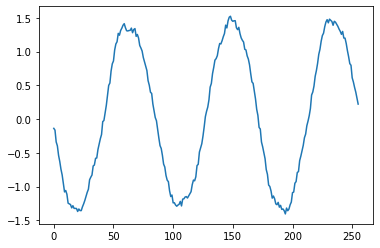

In [17]:
plt.plot(x[1])

In [18]:
batch_size = 128
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Model

In [19]:
def label_smoothing(y, α=0.):
    return y * (1 - α) + α / 2

In [73]:
class Model(nn.Module):
    
    def __init__(self, **params):
        super().__init__()
        
        input_size = params.get("input_size", 3)
        hidden_size = params.get("hidden_size", 16)
        bidirectional = params.get("bidirectional", False)
        kernel_size = params.get("kernel_size", 7)
        
        self.cnn = nn.Sequential(
            
            nn.Conv1d(input_size, hidden_size, padding="same", kernel_size=kernel_size),
            nn.BatchNorm1d(hidden_size),      
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(hidden_size, 1, padding="same", kernel_size=kernel_size),
            nn.BatchNorm1d(1),      
            nn.Sigmoid(),
            nn.MaxPool1d(2)
            
        )
        
        self.rnn = nn.LSTM(
            # input_size=input_size,
            input_size=hidden_size,
            hidden_size=hidden_size,
            bidirectional=bidirectional
        )
        
        d = 2 if bidirectional else 1
        
        self.tail = nn.Sequential(
            nn.Linear(hidden_size * d, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        
        # x: B, C, L  ->  L, B, C
        
        x = self.cnn(x)
        
#         output, _ = self.rnn(
#             torch.permute(x, (2, 0, 1))
#         )
        
#         L, B, C = output.shape
        
#         y = self.tail(
#             output.view(-1, C)
#         ).view(B, L)
        
        x = x.squeeze()
        y = x.repeat_interleave(4, dim=1)
        
        return y

In [74]:
torch.rand(1, 2, 3).squeeze()

tensor([[0.9809, 0.6740, 0.6792],
        [0.9845, 0.1494, 0.9969]])

In [75]:
model = Model(bidirectional=True)
model(torch.rand(7, 3, 256)).shape

torch.Size([7, 256])

In [76]:
x = dataset_train.X[:7]
y = dataset_train.Y[:7]

In [77]:
y.shape

torch.Size([7, 256])

In [78]:
y_pred = model(x)
y_pred.shape

torch.Size([7, 256])

In [79]:
def calculate_loss(y_pred, y_true, α=0.):
    return nn.functional.binary_cross_entropy(
        y_pred,
        label_smoothing(y_true, α)
    )

y_pred = model(x)
calculate_loss(y_pred, y)

tensor(0.7254, grad_fn=<BinaryCrossEntropyBackward0>)

In [80]:
y.shape

torch.Size([7, 256])

In [81]:
y_pred.shape

torch.Size([7, 256])

In [82]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

def accuracy(y_pred, y_true, balanced=False):
    # y_pred, y_true = trim(y_pred, y_true)
    f = balanced_accuracy_score if balanced else accuracy_score
    return f(
        (y_true.to("cpu") > 0.5).int().flatten(),
        (y_pred.to("cpu") > 0.5).int().flatten()
    )

In [83]:
accuracy(y_pred, y)

0.5379464285714286

# Train

In [84]:
def train_model(model, dataloader):
    
    losses = []
    scores = []
    
    model.train()

    # for x, y in tqdm(dataset, leave=False, position=1):
    for x, y in dataloader:
        
        x = x.to(device)
        y = y.to(device)  
        optimizer.zero_grad()
        y_pred = model(x)
        loss = calculate_loss(y_pred, y)     
        loss.backward()
        optimizer.step()

        score = accuracy(y_pred, y)
        
        losses.append(loss.item())
        scores.append(score)

    loss = np.mean(losses)
    score = np.mean(scores)
        
    return loss, score

In [85]:
def test_model(model, dataloader):
    
    losses = []
    scores = []
    
    with torch.no_grad():

        model.eval()
        
        # for x, y in tqdm(dataset, leave=False, position=1):
        for x, y in dataloader:
            
            x = x.to(device)
            y = y.to(device)  
                        
            y_pred = model(x)
            loss = calculate_loss(y_pred, y).item()
            score = accuracy(y_pred, y)
            
            losses.append(loss)
            scores.append(score)
            
    loss = np.mean(losses)
    score = np.mean(scores)
        
    return loss, score

In [86]:
def train_epoch(model, optimizer):
    
    objectives = {}
    
    # Train
    
    loss, score = train_model(model, train_dataloader)
    objectives["loss_train"] = loss
    objectives["score_train"] = score
    
    # Test

    loss, score = test_model(model, test_dataloader)
    objectives["loss_test"] = loss
    objectives["score_test"] = score

    return objectives

# Train

In [87]:
model = Model()

In [88]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3
)

In [89]:
model.to(device);

In [94]:
filename_model_save = "../models/rad-v3.0-arkit-latest.st"
score_test_best = 0.

rows = []

with trange(30) as t:
    for epoch in t:
        
        objectives = train_epoch(model, optimizer)
        rows.append(objectives)
        
        score_test = objectives["score_test"]
        if score_test > score_test_best:
            score_test_best = score_test
            # torch.save(model.state_dict(), filename_model_save)

        t.set_postfix(
            train=objectives["score_train"],
            test=score_test,
            best=score_test_best
        )

  0%|          | 0/30 [00:00<?, ?it/s]

In [95]:
df_progress = pd.DataFrame(rows)

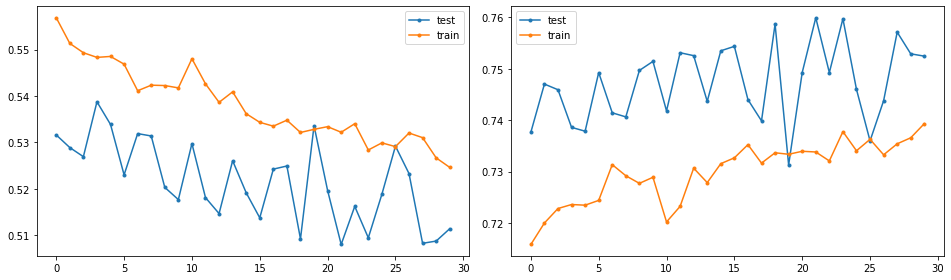

In [96]:
fig, axes = plt.subplots(ncols=2, figsize=plt.figaspect(0.3))

for i, key in enumerate(["loss", "score"]):

    ax = axes[i]
    plt.sca(ax)

    for t in "test", "train":
        plt.plot(df_progress[f"{key}_{t}"], ".-", label=t)

    plt.legend()
    # plt.yscale("log")

plt.tight_layout()

In [97]:
dataset = dataset_test
# dataset = dataset_train

y_pred = model(dataset.X).detach()
y_true = dataset.Y

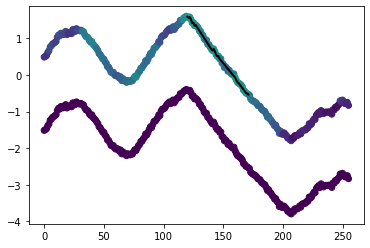

In [98]:
i = 126

x = dataset.X[i]
t = np.arange(x.shape[-1])

ix = 2

mask = y_pred[i] > 0.5

plt.scatter(t, x[ix], c=y_pred[i], vmin=0, vmax=1)
plt.plot(t[mask], x[ix][mask], "-k", lw=2)

plt.scatter(t, x[ix] - 2, c=y_true[i], vmin=0, vmax=1)

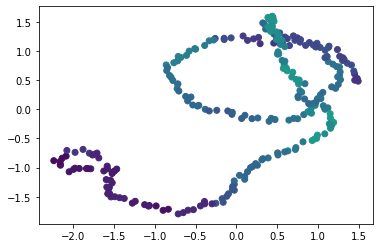

In [99]:
plt.scatter(x[0], x[2], c=y_pred[i], vmin=0, vmax=1)

(-0.1, 1.1)

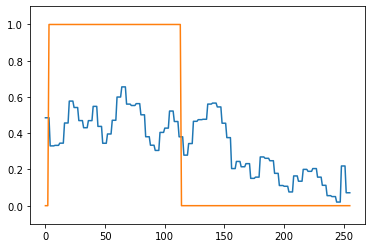

In [100]:
plt.plot(y_pred[0])
plt.plot(y_true[0])

plt.ylim(-0.1, 1.1)